In [50]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
# load dataset wine 
dataset = load_wine()
X = dataset['data']
y = dataset['target']
feature_names = dataset['feature_names']



In [51]:
# create dataframe to check for missing values

dataset_df = pd.DataFrame(X, columns=feature_names)
print(dataset_df.isna().sum())
print(dataset_df.info())

# No missing values found, 178 entries with 13 features each


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols         

In [52]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import accuracy_score
#clf = DecisionTreeClassifier(random_state=42)
#clf.fit(X, y)
#y_pred = clf.predict(X)
#accuracy_score(y, y_pred)


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


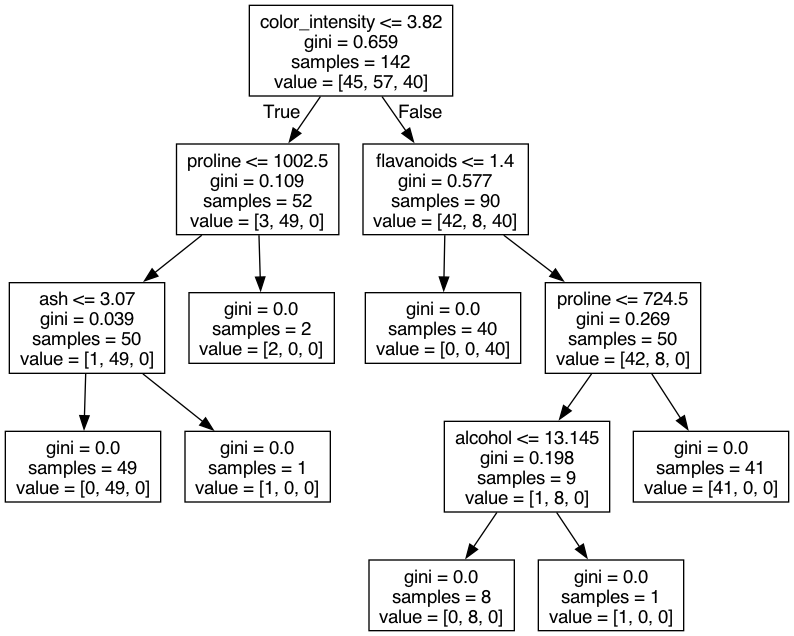

In [54]:
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_code = export_graphviz(clf, feature_names=feature_names)
graph = pydot.graph_from_dot_data(dot_code)
Image(graph[0].create_png())


In [55]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_score_value = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1_score_value:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Classification Report: \n, \n {report}')

#print( sum(y_pred == y_test), sum(y_pred != y_test)) 

Accuracy: 0.94
F1 Score: 0.94
Precision: 0.95
Recall: 0.94
Classification Report: 
, 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.93      1.00      0.97        14
           2       1.00      0.88      0.93         8

    accuracy                           0.94        36
   macro avg       0.95      0.93      0.94        36
weighted avg       0.95      0.94      0.94        36



In [56]:
from sklearn.model_selection import ParameterGrid

# naive hyperparameters tuning, in reality we need validation set to define the hyperparameters

params = {
    'max_depth': [None, 2, 4, 8],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 3, 4, 5],              # this is a dictionary of possible parameters for our clf
    'min_samples_leaf': [1, 2, 3],
}

clf = DecisionTreeClassifier(**params)

for param_combination in ParameterGrid(params):
    clf.set_params(**param_combination)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)                                                #test the accuracy with different hyperparameters
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy >= 0.97:
        print(f'Params: {param_combination}, Accuracy: {accuracy:.2f}')

Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}, Accuracy: 0.97
Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'random'}, Accuracy: 0.97
Params: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 4, 'splitter': 'random'}, Accuracy: 0.97
Params: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}, Accuracy: 1.00
Params: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}, Accuracy: 0.97
Params: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'random'}, Accuracy: 0.97


In [57]:
from sklearn.model_selection import KFold

# now we perform the k-fold cross validation
# split the dataset in X_train_valid and X_test, the first one is for the cross validation, the other one is for the test

X_train_valid, X_test_fin, y_train_valid, y_test_fin = train_test_split(X, y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'max_depth': [None, 2, 4, 8],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 3, 4, 5], 
    'min_samples_leaf': [1, 2, 3],          
}

clf_fin = DecisionTreeClassifier(random_state=42)


for param_combination in ParameterGrid(params):
    n_splits = kf.get_n_splits()
    accuracy_arr = np.zeros(n_splits)
    i = 0

    for train_indices, validation_indices in kf.split(X_train_valid):
        # training fold
        X_train_fin = X_train_valid[train_indices]
        y_train_fin = y_train_valid[train_indices]
        # validation fold
        X_valid = X_train_valid[validation_indices]
        y_valid = y_train_valid[validation_indices]

        clf_fin.set_params(**param_combination)
        # Fit on the training fold (not on validation)
        clf_fin.fit(X_train_fin, y_train_fin)
        # Evaluate on the validation fold
        y_pred = clf_fin.predict(X_valid)
        accuracy_arr[i] = accuracy_score(y_valid, y_pred)
        i += 1

    mean_acc = np.mean(accuracy_arr)
    if mean_acc >= 0.92:
        print(f'Params: {param_combination}, CV Accuracy: {mean_acc:.3f}')


Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}, CV Accuracy: 0.947
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}, CV Accuracy: 0.947
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}, CV Accuracy: 0.947
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}, CV Accuracy: 0.932
Params: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}, CV Accuracy: 0.925
Params: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'best'}, CV Accuracy: 0.925
Params: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'splitter': 'best'}, CV Accuracy: 0.925
Params: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'splitter': 'best'}, CV Accuracy: 0.925
Params: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitte